# Install & Import

In [1]:
# Install
!pip install pulp --quiet
!pip install ultralytics --quiet


# Import Libraries
import os
import subprocess
import asyncio
import importlib
import time
import shutil
import random
import copy
import glob
import pulp
import uuid
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
subprocess.run(['pip', 'install', 'ultralytics'], capture_output=True)
from ultralytics import YOLO
from ultralytics.data.dataset import ClassificationDataset
from ultralytics.models.yolo.classify import ClassificationTrainer, ClassificationValidator
from IPython.core.interactiveshell import InteractiveShell
from PIL import Image
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
from datetime import datetime
from sklearn.model_selection import KFold, GroupShuffleSplit
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
import torch.optim as optim
from torchvision.models import mobilenet_v2, MobileNet_V3_Small_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━

E0000 00:00:1762545205.207202      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762545205.257921      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Check GPU Availability
torch.cuda.empty_cache()
print(torch.cuda.is_available())

True


# EDA

In [4]:
# Path & Variables

home_path = "/kaggle/working" 
dataset_path = "/kaggle/input/dataset-s1-v2"
folder_save = "/kaggle/working/results"
class_names = ['3dmask', 'deepfake', 'print', 'real', 'replay'] 
num_classes = len(class_names)
     
random.seed(42)

In [ ]:
# Dataset Distribution

def count_images_in_classes(folder_path):
    """Count the number of images in each class folder."""
    class_counts = {}
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path): 
            class_counts[class_folder] = len([
                f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))
            ])
    return class_counts

def plot_distribution(class_counts, title):
    """Display dataset distribution using a bar graph."""
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show() 

datasets_class_counts = count_images_in_classes(dataset_path)
print(f"Dataset distribution: {datasets_class_counts}")
plot_distribution(datasets_class_counts, "Dataset Distribution")

In [ ]:
# Preview Datasets

def preview_images(folder_path, title, samples_per_class=5):
    import os
    import matplotlib.pyplot as plt
    from PIL import Image

    # Get all classes (folders)
    classes = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    num_classes = len(classes)

    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))
    
    # Flatten axes for easy indexing
    axes = axes.flatten() if num_classes * samples_per_class > 1 else [axes]

    fig.suptitle(title, fontsize=16)

    for i, cls in enumerate(classes):
        class_path = os.path.join(folder_path, cls)
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Filter images starting with class name
        sample_images = [img for img in images if img.startswith(cls + "_")][:samples_per_class]

        for j in range(samples_per_class):
            ax = axes[i * samples_per_class + j]
            ax.axis('off')

            if j < len(sample_images):
                img_path = os.path.join(class_path, sample_images[j])
                img = Image.open(img_path).convert("RGB")
                ax.imshow(img)
                if j == 0:
                    ax.set_title(cls)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Preview images in folder
preview_images(dataset_path, "Dataset Preview", samples_per_class=5)

# Data Split

In [3]:
# Define the output path
output_base_dir = "/kaggle/working/dataset-s1-v2-602020"  # Output directory name
if os.path.exists(output_base_dir):
    shutil.rmtree(output_base_dir)
os.makedirs(output_base_dir, exist_ok=True)

# Initialize lists to store file paths, labels, and video IDs
file_paths = []
labels = []
video_ids = []

# Scan dataset folders and collect image file information
print("Scanning dataset folders...")
for folder in class_names:
    class_path = os.path.join(dataset_path, folder)
    if not os.path.isdir(class_path):
        print(f"Warning: Directory not found at {class_path}. Skipping.")
        continue
    for filename in os.listdir(class_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_file_path = os.path.join(class_path, filename)
            file_paths.append(full_file_path)
            labels.append(folder)
            # Generate unique video ID based on folder and filename
            base_video_id = os.path.splitext(filename)[0].split('_')[0]
            unique_video_id = f"{folder}_{base_video_id}"
            video_ids.append(unique_video_id)

# Create a DataFrame to store the collected data
df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels,
    'video_id': video_ids
})

# Encode labels numerically
df['label_encoded'], unique_labels = pd.factorize(df['label'])
class_names = unique_labels.tolist()

# Print dataset statistics
print(f"\nFound {len(df)} total frames from {df['video_id'].nunique()} unique videos.")
print(f"Class names: {class_names}")
print("\n" + "="*60 + "\n")

# Perform stratified splitting: 70% train, 15% val, 15% test
# print("Performing stratified split (70% train, 15% val, 15% test)...")
# train_val_df, test_df = train_test_split(
#     df,
#     test_size=0.15,
#     random_state=42,
#     stratify=df['label_encoded']
# )
# train_df, val_df = train_test_split(
#     train_val_df,
#     test_size=0.1765,  # 15% of original = 17.65% of (train+val)
#     random_state=42,
#     stratify=train_val_df['label_encoded']
# )

# Perform stratified splitting: 65% train, 15% val, 20% test
# print("Performing stratified split (65% train, 15% val, 20% test)...")
# train_val_df, test_df = train_test_split(
#     df,
#     test_size=0.20,  # 20% for test
#     random_state=42,
#     stratify=df['label_encoded']
# )
# train_df, val_df = train_test_split(
#     train_val_df,
#     test_size=0.1875,  # 15% of original = 18.75% of (train+val)
#     random_state=42,
#     stratify=train_val_df['label_encoded']
# )

# Perform stratified splitting: 65% train, 20% val, 15% test
# print("Performing stratified split (65% train, 20% val, 15% test)...")
# train_val_df, test_df = train_test_split(
#     df,
#     test_size=0.15,  # 15% for test
#     random_state=42,
#     stratify=df['label_encoded']
# )
# train_df, val_df = train_test_split(
#     train_val_df,
#     test_size=0.2353,  # 20% of original = 23.53% of (train+val)
#     random_state=42,
#     stratify=train_val_df['label_encoded']
# )

# Perform stratified splitting: 80% train, 10% val, 10% test
# print("Performing stratified split (80% train, 10% val, 10% test)...")
# train_val_df, test_df = train_test_split(
#     df,
#     test_size=0.10,  # 10% for test
#     random_state=42,
#     stratify=df['label_encoded']
# )
# train_df, val_df = train_test_split(
#     train_val_df,
#     test_size=0.1111,  # 10% of original = 11.11% of (train+val)
#     random_state=42,
#     stratify=train_val_df['label_encoded']
# )

# Perform stratified splitting: 60% train, 20% val, 20% test
print("Performing stratified split (60% train, 20% val, 20% test)...")
train_val_df, test_df = train_test_split(
    df,
    test_size=0.20,  # 20% for test
    random_state=42,
    stratify=df['label_encoded']
)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.25,  # 20% of original = 25% of (train+val)
    random_state=42,
    stratify=train_val_df['label_encoded']
)

# Print split statistics
print("\nSplit complete. Final set sizes:")
print(f"Training set: {len(train_df)} frames ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation set: {len(val_df)} frames ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test set: {len(test_df)} frames ({len(test_df)/len(df)*100:.1f}%)")
print("\n" + "="*60 + "\n")

# Create output directory structure
print("Creating output directory structure...")
os.makedirs(output_base_dir, exist_ok=True)
for split in ['train', 'val', 'test']:
    split_dir = os.path.join(output_base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for class_name in class_names:
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# Copy files to respective split folders
print("Copying files to split folders...")
def copy_files(df, split_name):
    for _, row in df.iterrows():
        src_path = row['file_path']
        class_name = row['label']
        # Generate unique filename to avoid overwrites
        filename = os.path.basename(src_path)
        base, ext = os.path.splitext(filename)
        unique_filename = f"{base}_{uuid.uuid4().hex[:8]}{ext}"
        dest_path = os.path.join(output_base_dir, split_name, class_name, unique_filename)
        shutil.copy2(src_path, dest_path)

copy_files(train_df, 'train')
copy_files(val_df, 'val')
copy_files(test_df, 'test')

# Verify the number of files in each split and class
print("\nVerifying output directory contents...")
for split in ['train', 'val', 'test']:
    print(f"\n{split.capitalize()} set:")
    split_dir = os.path.join(output_base_dir, split)
    for class_name in class_names:
        class_dir = os.path.join(split_dir, class_name)
        num_files = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"  {class_name}: {num_files} files")
print("\nDataset splitting and organization complete!")

Scanning dataset folders...

Found 15000 total frames from 3005 unique videos.
Class names: ['3dmask', 'deepfake', 'print', 'real', 'replay']


Performing stratified split (60% train, 20% val, 20% test)...

Split complete. Final set sizes:
Training set: 9000 frames (60.0%)
Validation set: 3000 frames (20.0%)
Test set: 3000 frames (20.0%)


Creating output directory structure...
Copying files to split folders...

Verifying output directory contents...

Train set:
  3dmask: 1800 files
  deepfake: 1800 files
  print: 1800 files
  real: 1800 files
  replay: 1800 files

Val set:
  3dmask: 600 files
  deepfake: 600 files
  print: 600 files
  real: 600 files
  replay: 600 files

Test set:
  3dmask: 600 files
  deepfake: 600 files
  print: 600 files
  real: 600 files
  replay: 600 files

Dataset splitting and organization complete!


# Data Augmentation

In [5]:
# Define Transforms
output_size = (224, 224)

crop_factor = 0.5 
crop_size = (int(output_size[0] * crop_factor), int(output_size[1] * crop_factor))

transform_train = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(10),
    v2.RandomResizedCrop(size=224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    v2.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    v2.RandomPerspective(distortion_scale=0.1, p=0.3),
    v2.GaussianNoise(mean=0, sigma=0.02),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    v2.RandomErasing(p=0.15, scale=(0.02, 0.15)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_ori = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.GaussianNoise(mean=0, sigma=0.02),
    # v2.GaussianBlur(kernel_size=1, sigma=0.3),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val_test = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.GaussianNoise(mean=0, sigma=0.02),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Path splitted dataset
data_dir = "/kaggle/working/dataset-s1-v2-602020"

# Two train datasets: original + augmented
train_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_ori)
train_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform_train)

# Concatenate original + augmented datasets to enrich training data
train_dataset = ConcatDataset([train_dataset_ori, train_dataset_aug])

# Validation and Test datasets
# val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_val_test)
# test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_val_test)
# test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_ori)
# test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"))

# Two val datasets: original + augmented
val_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_ori)
val_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich validation data
val_dataset = ConcatDataset([val_dataset_ori, val_dataset_aug])

# Two test datasets: original + augmented
test_dataset_ori = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_ori)
test_dataset_aug = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform_val_test)

# Concatenate original + augmented datasets to enrich testing data
test_dataset = ConcatDataset([test_dataset_ori, test_dataset_aug])

# Class names (from original dataset)
class_names = train_dataset_ori.classes
print("Classes:", class_names)

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [7]:
# Function to count class distribution

def get_class_distribution(dataset, dataset_name="Dataset"):
    """
    Calculate and print class distribution for an ImageFolder or ConcatDataset.
    
    Args:
        dataset: ImageFolder or ConcatDataset
        dataset_name: str, name for display (e.g., "Train Dataset")
    
    Returns:
        DataFrame with class counts
    """
    if isinstance(dataset, ConcatDataset):
        # If it's a ConcatDataset -> collect all targets from sub-datasets
        targets = []
        for ds in dataset.datasets:
            targets.extend(ds.targets)
    else:
        # If it's just a single ImageFolder
        targets = dataset.targets

    # Count occurrences of each class index
    counter = Counter(targets)

    # Build DataFrame with class names and counts
    df = pd.DataFrame({
        "Class": [class_names[i] for i in counter.keys()],
        "Count": list(counter.values())
    }).sort_values("Class").reset_index(drop=True)

    # Print results
    print(f"\n{dataset_name} total: {len(dataset)} samples")
    print(df.to_string(index=False))
    return df


# Check Train / Validation / Test dataset distribution
print("="*60)
train_dist = get_class_distribution(train_dataset, "Train Dataset")

print("="*60)
val_dist = get_class_distribution(val_dataset, "Validation Dataset")

print("="*60)
test_dist = get_class_distribution(test_dataset, "Test Dataset")


Train Dataset total: 18000 samples
   Class  Count
  3dmask   3600
deepfake   3600
   print   3600
    real   3600
  replay   3600

Validation Dataset total: 6000 samples
   Class  Count
  3dmask   1200
deepfake   1200
   print   1200
    real   1200
  replay   1200

Test Dataset total: 6000 samples
   Class  Count
  3dmask   1200
deepfake   1200
   print   1200
    real   1200
  replay   1200


In [ ]:
# Preview Augmented Data

def show_sample_images(dataset, class_names, num_samples=2):
    """Visualize a few samples from each class."""
    class_samples = {cls: [] for cls in class_names}
    for img, label in dataset:
        class_name = class_names[label]
        if len(class_samples[class_name]) < num_samples:
            class_samples[class_name].append(img)
            if all(len(samples) >= num_samples for samples in class_samples.values()):
                break

    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(num_samples * 3, len(class_names) * 3))
    for i, (class_name, samples) in enumerate(class_samples.items()):
        for j, img in enumerate(samples):
            ax = axes[i, j] if len(class_names) > 1 else axes[j]
            image = img.permute(1, 2, 0).numpy()
            image = (image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])  # denormalize
            image = np.clip(image, 0, 1)
            ax.imshow(image)
            ax.set_title(class_name)
            ax.axis('off')
    plt.tight_layout()
    plt.show()

print("Sample images from original training dataset:")
show_sample_images(train_dataset_ori, class_names, num_samples=2)

print("Sample images from augmented training dataset:")
show_sample_images(train_dataset_aug, class_names, num_samples=2)

# Single Models

## YOLOv11

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from ultralytics import YOLO
import itertools
import random
import time
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# =========================================
# ⚙️ Utility Function: Replace Classifier
# =========================================
def replace_classifier(model, num_classes, dropout):
    torch_model = model.model
    if hasattr(torch_model, "model") and hasattr(torch_model.model[10], "linear"):
        in_features = torch_model.model[10].linear.in_features
        torch_model.model[10].linear = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(in_features, num_classes)
        )
        print(f"✅ Classifier replaced: in_features={in_features}, dropout={dropout}")
    else:
        raise AttributeError("❌ Tidak ditemukan layer klasifikasi (model.model[10].linear).")
    return torch_model


# =========================================
# ⚙️ Training Function
# =========================================
def train_and_eval(config, train_dataset, val_dataset, num_classes, epochs=3):
    model = YOLO("yolo11s-cls.pt")
    torch_model = replace_classifier(model, num_classes, config["DROPOUT"])
    torch_model = torch_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, torch_model.parameters()),
        lr=config["LR"],
        weight_decay=config["WEIGHT_DECAY"]
    )

    train_loader = DataLoader(train_dataset, batch_size=config["BATCH_SIZE"], shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=config["BATCH_SIZE"], shuffle=False, num_workers=2)

    best_val_acc = 0.0
    torch_model.train()

    for epoch in range(epochs):
        torch_model.train()
        running_loss, correct, total = 0.0, 0, 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = torch_model(imgs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

        train_acc = correct / total
        torch_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = torch_model(imgs)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels).item()
                total += labels.size(0)
        val_acc = correct / total

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc, torch_model


# =========================================
# ⚙️ Stage A: Coarse Grid Search
# =========================================
EPOCHS_STAGE_A = 5  # ringankan beban GPU
num_classes = 5

# misal dataset sudah terdefinisi
# train_dataset, val_dataset = ...

subset_train = Subset(train_dataset, random.sample(range(len(train_dataset)), 2000))
subset_val = Subset(val_dataset, random.sample(range(len(val_dataset)), 500))

param_grid = {
    "BATCH_SIZE": [32, 64],
    "LR": [1e-3, 5e-4, 1e-4, 5e-5],
    "WEIGHT_DECAY": [1e-2, 1e-3, 5e-3, 5e-4],
    "DROPOUT": [0.2, 0.3, 0.5, 0.6],
}

grid_combinations = list(itertools.product(*param_grid.values()))
results_stageA = []
best_acc, best_config = 0, None

print("\n🚀 Starting Stage A (Coarse Search)...")
for i, combo in enumerate(grid_combinations):
    config = dict(zip(param_grid.keys(), combo))
    print(f"\n🔹 Trial {i+1}/{len(grid_combinations)} | Config: {config}")
    acc, _ = train_and_eval(config, subset_train, subset_val, num_classes, EPOCHS_STAGE_A)
    results_stageA.append((config, acc))
    if acc > best_acc:
        best_acc = acc
        best_config = config.copy()
        print(f"\n🏆 New Best Found! Accuracy: {best_acc:.4f} | Config: {best_config}")

print("\n✅ Stage A Complete!")
print(f"🔥 Best Config (Stage A): {best_config} | Val Acc: {best_acc:.4f}")

# =========================================
# ⚙️ Stage B: Fine-tuned Grid Search
# =========================================
EPOCHS_STAGE_B = 8
best_bs, best_lr, best_wd, best_do = best_config.values()

param_grid_B = {
    "BATCH_SIZE": [best_bs],
    "LR": [best_lr * 0.5, best_lr, best_lr * 1.5],
    "WEIGHT_DECAY": [best_wd * 0.5, best_wd, best_wd * 2],
    "DROPOUT": [max(0.0, best_do - 0.1), best_do, min(0.7, best_do + 0.1)],
}

grid_combinations_B = list(itertools.product(*param_grid_B.values()))
results_stageB = []
best_acc_B, best_config_B = 0, None

print("\n🚀 Starting Stage B (Fine-tuned Search)...")
for i, combo in enumerate(grid_combinations_B):
    config = dict(zip(param_grid_B.keys(), combo))
    print(f"\n🔸 Trial {i+1}/{len(grid_combinations_B)} | Config: {config}")
    acc, _ = train_and_eval(config, subset_train, subset_val, num_classes, EPOCHS_STAGE_B)
    results_stageB.append((config, acc))
    if acc > best_acc_B:
        best_acc_B = acc
        best_config_B = config.copy()
        print(f"\n🏆 New Best (Stage B)! Acc: {best_acc_B:.4f} | Config: {best_config_B}")

print("\n✅ Stage B Complete!")
print(f"🔥 Final Best Config: {best_config_B} | Val Acc: {best_acc_B:.4f}")


### Pytorch

In [70]:
# Check GPU Availability
print(torch.cuda.is_available())

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [116]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001 # 0.0001, 0,00001, 0.0001, 0.00001
WEIGHT_DECAY=0.005 # 0.005, 0.001, 0.05, 0.1, 0.5
DROPOUT=0.2 # 0.2

In [117]:
# Create Data Loader 

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [118]:
# Load pretrained YOLO11s-cls
model = YOLO("yolo11s-cls.pt")
torch_model = model.model  # Access underlying ClassificationModel

# Replace final classifier layer
in_features = torch_model.model[10].linear.in_features
torch_model.model[10].linear = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
torch_model = torch_model.to(device)

In [119]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, torch_model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

# Scheduler
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
# scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode='min',    
#     factor=0.5,    
#     patience=2,    
#     min_lr=0.00001,
#     verbose=True   
# )

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import time
import optuna
from ultralytics import YOLO
import optuna.visualization as vis

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained YOLO11s-cls
model = YOLO("yolo11s-cls.pt")  # Pastikan file model tersedia
torch_model = model.model  # Akses model PyTorch internal

# Unfreeze model parameters for fine-tuning
for param in torch_model.parameters():
    param.requires_grad = True  # Pastikan semua parameter dapat dilatih
torch_model.to(device)

# Training Function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including saving best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.6f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()
        scheduler.step(history['val_loss'][-1])
    
    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

# Optuna Objective Function
def objective(trial):
    # Define hyperparameter search space
    config = {
        "lr": trial.suggest_categorical("lr", [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]),
        "weight_decay": trial.suggest_categorical("weight_decay", [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]),
        "dropout": trial.suggest_categorical("dropout", [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64]),
    }

    # Load and wrap model
    model = YOLO("yolo11s-cls.pt")
    class YOLOWrapper(nn.Module):
        def __init__(self, base_model, dropout_rate):
            super(YOLOWrapper, self).__init__()
            self.base_model = base_model.model
            # Pastikan parameter dari base_model dapat dilatih
            for param in self.base_model.parameters():
                param.requires_grad = True
            self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()

        def forward(self, x):
            x = self.base_model(x)
            if isinstance(x, tuple):
                x = x[0]  # Ambil output klasifikasi
            x = self.dropout(x)  # Terapkan dropout pada output
            return x

    wrapped_model = YOLOWrapper(model, config["dropout"])
    wrapped_model.to(device)

    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        wrapped_model.parameters(),  # Gunakan parameters() langsung dari wrapped_model
        lr=config["lr"],
        weight_decay=config["weight_decay"]
    )
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6, verbose=True)

    # Train the model
    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=2)
    trained_model, history, best_val_accuracy = train_model(
        model=wrapped_model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        num_epochs=10  # 10 epoch per trial untuk efisiensi
    )

    # Hitung metrik maksimum
    max_train_acc = max(history["train_acc"])
    max_val_acc = max(history["val_acc"])
    max_train_loss = max(history["train_loss"])
    max_val_loss = max(history["val_loss"])

    # Penalti 1: Jika val_acc > train_acc
    val_acc_penalty = max(0, max_val_acc - max_train_acc) * 1.0  # Bobot penalti 1.0 jika val_acc melebihi train_acc

    # Penalti 2: Gap antara train_acc dan val_acc
    acc_gap = abs(max_train_acc - max_val_acc)
    acc_gap_penalty = max(0, acc_gap - 0.05) * 0.5  # Penalti jika gap > 5%, dengan bobot 0.5

    # Penalti 3: Gap antara train_loss dan val_loss
    loss_gap = abs(max_train_loss - max_val_loss)
    loss_gap_penalty = max(0, loss_gap - 0.1) * 0.5  # Penalti jika gap > 0.1, dengan bobot 0.5

    # Hitung final score
    final_score = max_val_acc - val_acc_penalty - acc_gap_penalty - loss_gap_penalty

    # Report intermediate results for pruning
    trial.report(final_score, len(history["val_acc"]) - 1)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return final_score

# Callback untuk menampilkan kombinasi terbaik secara berkala
def on_trial_complete(study, trial):
    if study.best_trial.number == trial.number:
        print(f"\n=== Current Best Combination (Trial {trial.number}):")
        print(f"Params: {study.best_params}")
        print(f"Best Score: {study.best_value:.3f}")
        print("=====================================")

# Run Optuna Optimization
n_trials = 30
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=n_trials, n_jobs=2, callbacks=[on_trial_complete])  # Paralelisme dengan 2 jobs

# Visualisasi hasil
print("\n==============================")
print("Optimization History:")
vis.plot_optimization_history(study).show()
print("Parameter Importance:")
vis.plot_param_importances(study).show()

# Print final results
print("\n==============================")
print("Best Config Found:")
print(study.best_params)
print(f"Best Adjusted Validation Score: {study.best_value:.3f}")
print("==============================")

# Print all completed trials
for i, trial in enumerate(study.trials, 1):
    if trial.state == optuna.trial.TrialState.COMPLETED:
        print(f"{i}. {trial.params} | Score={trial.value:.3f}")
    elif trial.state == optuna.trial.TrialState.PRUNED:
        print(f"{i}. {trial.params} | Pruned")

In [ ]:
# optuna (rev)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import time
import optuna
from ultralytics import YOLO
import optuna.visualization as vis

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained YOLO11s-cls
model = YOLO("yolo11s-cls.pt")  # Pastikan file model tersedia
torch_model = model.model  # Akses model PyTorch internal

# Unfreeze model parameters for fine-tuning
for param in torch_model.parameters():
    param.requires_grad = True  # Pastikan semua parameter dapat dilatih
torch_model.to(device)

# Training Function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, scheduler, device, num_epochs=25):
    """Trains and validates a model, including saving best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.6f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()
        scheduler.step(history['val_loss'][-1])  # Gunakan scheduler yang diteruskan
    
    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

# Optuna Objective Function
def objective(trial):
    # Define hyperparameter search space
    config = {
        "lr": trial.suggest_categorical("lr", [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]),
        "weight_decay": trial.suggest_categorical("weight_decay", [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]),
        "dropout": trial.suggest_categorical("dropout", [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64]),
    }

    # Load and wrap model
    model = YOLO("yolo11s-cls.pt")
    class YOLOWrapper(nn.Module):
        def __init__(self, base_model, dropout_rate):
            super(YOLOWrapper, self).__init__()
            self.base_model = base_model.model
            # Pastikan parameter dari base_model dapat dilatih
            for param in self.base_model.parameters():
                param.requires_grad = True
            self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()

        def forward(self, x):
            x = self.base_model(x)
            if isinstance(x, tuple):
                x = x[0]  # Ambil output klasifikasi
            x = self.dropout(x)  # Terapkan dropout pada output
            return x

    wrapped_model = YOLOWrapper(model, config["dropout"])
    wrapped_model.to(device)

    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        wrapped_model.parameters(),  # Gunakan parameters() langsung dari wrapped_model
        lr=config["lr"],
        weight_decay=config["weight_decay"]
    )
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6, verbose=True)

    # Train the model
    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=2)
    val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=2)
    trained_model, history, best_val_accuracy = train_model(
        model=wrapped_model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        optimizer=optimizer,
        criterion=criterion,
        scheduler=scheduler,  # Tambahkan scheduler sebagai argumen
        device=device,
        num_epochs=10  # 10 epoch per trial untuk efisiensi
    )

    # Hitung metrik maksimum
    max_train_acc = max(history["train_acc"])
    max_val_acc = max(history["val_acc"])
    max_train_loss = max(history["train_loss"])
    max_val_loss = max(history["val_loss"])

    # Penalti 1: Jika val_acc > train_acc
    val_acc_penalty = max(0, max_val_acc - max_train_acc) * 1.0  # Bobot penalti 1.0 jika val_acc melebihi train_acc

    # Penalti 2: Gap antara train_acc dan val_acc
    acc_gap = abs(max_train_acc - max_val_acc)
    acc_gap_penalty = max(0, acc_gap - 0.05) * 0.5  # Penalti jika gap > 5%, dengan bobot 0.5

    # Penalti 3: Gap antara train_loss dan val_loss
    loss_gap = abs(max_train_loss - max_val_loss)
    loss_gap_penalty = max(0, loss_gap - 0.1) * 0.5  # Penalti jika gap > 0.1, dengan bobot 0.5

    # Hitung final score
    final_score = max_val_acc - val_acc_penalty - acc_gap_penalty - loss_gap_penalty

    # Report intermediate results for pruning
    trial.report(final_score, len(history["val_acc"]) - 1)
    if trial.should_prune():
        raise optuna.TrialPruned()

    return final_score

# Callback untuk menampilkan kombinasi terbaik secara berkala
def on_trial_complete(study, trial):
    if study.best_trial.number == trial.number:
        print(f"\n=== Current Best Combination (Trial {trial.number}):")
        print(f"Params: {study.best_params}")
        print(f"Best Score: {study.best_value:.3f}")
        print("=====================================")

# Run Optuna Optimization
n_trials = 20
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=n_trials, n_jobs=2, callbacks=[on_trial_complete])  # Paralelisme dengan 2 jobs

# Visualisasi hasil
print("\n==============================")
print("Optimization History:")
vis.plot_optimization_history(study).show()
print("Parameter Importance:")
vis.plot_param_importances(study).show()

# Print final results
print("\n==============================")
print("Best Config Found:")
print(study.best_params)
print(f"Best Adjusted Validation Score: {study.best_value:.3f}")
print("==============================")

# Print all completed trials
for i, trial in enumerate(study.trials, 1):
    if trial.state == optuna.trial.TrialState.COMPLETED:
        print(f"{i}. {trial.params} | Score={trial.value:.3f}")
    elif trial.state == optuna.trial.TrialState.PRUNED:
        print(f"{i}. {trial.params} | Pruned")

In [120]:
# Training Function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including saving best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.model.state_dict())
    model.model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.6f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.model.train()
                dataloader = train_dataloader
            else:
                model.model.eval()
                dataloader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])
    
    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')
    model.model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [121]:
# Training
best_model, history, best_val_accuracy = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
) # LR: 0.000100 | Train Loss: 0.1155 Acc: 0.9556 | Val Loss: 0.9594 Acc: 0.9645

Epoch 1/20 =>  LR: 0.000100 | Train Loss: 0.6583 Acc: 0.7972 | Val Loss: 1.0741 Acc: 0.9237 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.000100 | Train Loss: 0.3034 Acc: 0.9056 | Val Loss: 1.0241 Acc: 0.9390 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.000100 | Train Loss: 0.2442 Acc: 0.9174 | Val Loss: 1.0036 Acc: 0.9448 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.000100 | Train Loss: 0.2134 Acc: 0.9267 | Val Loss: 0.9928 Acc: 0.9498 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.000100 | Train Loss: 0.1930 Acc: 0.9313 | Val Loss: 0.9855 Acc: 0.9528 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.000100 | Train Loss: 0.1809 Acc: 0.9344 | Val Loss: 0.9786 Acc: 0.9552 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.000100 | Train Loss: 0.1688 Acc: 0.9381 | Val Loss: 0.9768 Acc: 0.9547 | 
Epoch 8/20 =>  LR: 0.000100 | Train Loss: 0.1643 Acc: 0.9392 | Val Loss: 0.9727 Acc: 0.9562 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.000100 | Train Loss: 0.1583 Acc: 0.9392 | Va

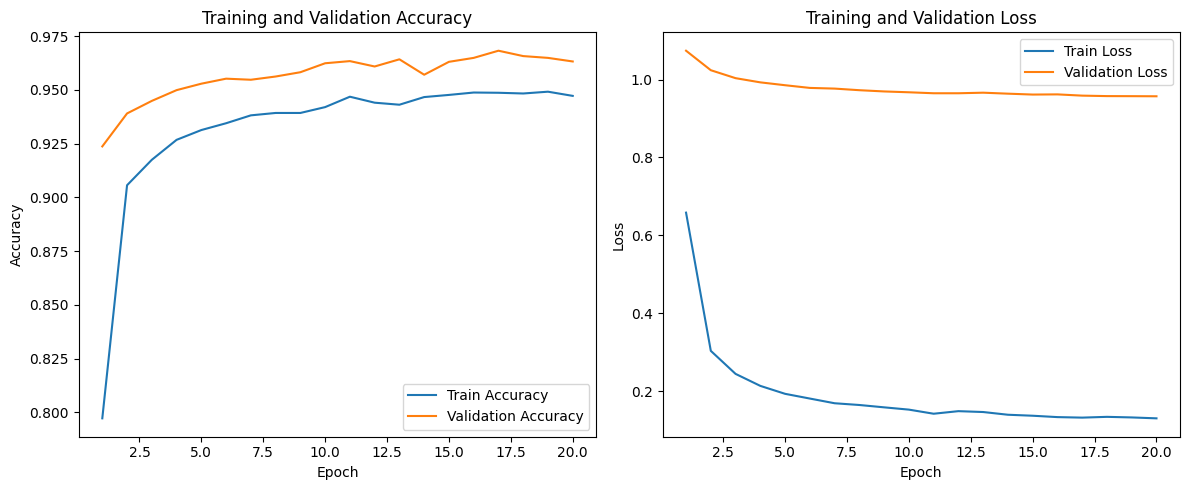

In [124]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [125]:
# Model Evaluation
best_model.model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model.model(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))


Classification Report:
              precision    recall  f1-score   support

      3dmask       0.99      1.00      0.99      1200
    deepfake       0.91      0.93      0.92      1200
       print       1.00      1.00      1.00      1200
        real       0.93      0.90      0.92      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000



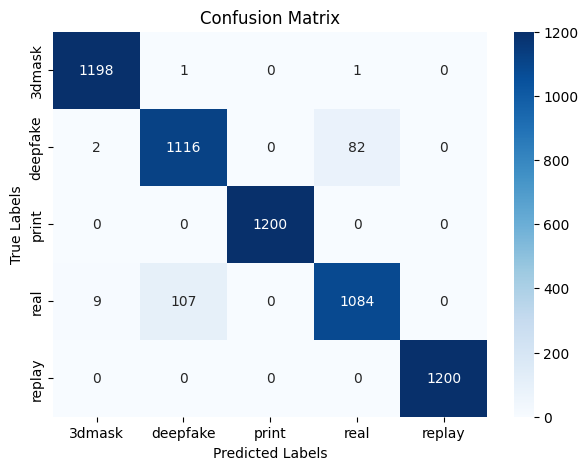

In [126]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [127]:
# Update class metadata before saving
best_model.model.nc = num_classes
best_model.model.names = {i: name for i, name in enumerate(class_names)}  # Dictionary for class name

# Create subfolder with name 'yolo11_{date}_{acc}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"yolo11_{current_date}_{best_val_accuracy:.4f}")
try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model using Ultralytics API
full_model_path = os.path.join(save_dir, 'YOLOv11-full-model.pt')
try:
    best_model.save(full_model_path)  # Save with class metadata
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save checkpoint with history
checkpoint = {
    "model": best_model.model.state_dict(),
    "history": history,
    "best_val_acc": best_val_accuracy,
    "class_names": class_names,
    "nc": num_classes
}
checkpoint_path = os.path.join(save_dir, 'YOLOv11-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Full model saved to /kaggle/working/results/yolo11_10-21-17_0.9682/YOLOv11-full-model.pt
Checkpoint with history saved to /kaggle/working/results/yolo11_10-21-17_0.9682/YOLOv11-with-history.pt
All models successfully saved to /kaggle/working/results/yolo11_10-21-17_0.9682


In [71]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.00001 # 0.0001, 0,00001, 0.0001, 0.00001
WEIGHT_DECAY=0.005 # 0.005, 0.001, 0.05, 0.1, 0.5
DROPOUT=0.2 # 0.2

# Create Data Loader 
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [72]:
# Load pretrained YOLO11s-cls
model = YOLO("yolo11s-cls.pt")
torch_model = model.model  # Access underlying ClassificationModel

# Replace final classifier layer
in_features = torch_model.model[10].linear.in_features
torch_model.model[10].linear = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
torch_model = torch_model.to(device)

In [73]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, torch_model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

# Scheduler
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
# scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode='min',    
#     factor=0.5,    
#     patience=2,    
#     min_lr=0.00001,
#     verbose=True   
# )

In [74]:
# Training Function
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including saving best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.model.state_dict())
    model.model.to(device)
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.6f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.model.train()
                dataloader = train_dataloader
            else:
                model.model.eval()
                dataloader = val_dataloader
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')
            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])
    
    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')
    model.model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

Epoch 1/20 =>  LR: 0.000010 | Train Loss: 1.4055 Acc: 0.4344 | Val Loss: 1.4580 Acc: 0.7057 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.000010 | Train Loss: 0.9960 Acc: 0.7118 | Val Loss: 1.3283 Acc: 0.8320 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.000010 | Train Loss: 0.7716 Acc: 0.7962 | Val Loss: 1.2513 Acc: 0.8627 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.000010 | Train Loss: 0.6328 Acc: 0.8332 | Val Loss: 1.1912 Acc: 0.8847 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.000010 | Train Loss: 0.5514 Acc: 0.8508 | Val Loss: 1.1573 Acc: 0.8923 | >>> New best model saved!
Epoch 6/20 =>  LR: 0.000010 | Train Loss: 0.4878 Acc: 0.8653 | Val Loss: 1.1291 Acc: 0.9048 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.000010 | Train Loss: 0.4414 Acc: 0.8704 | Val Loss: 1.1059 Acc: 0.9100 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.000010 | Train Loss: 0.4049 Acc: 0.8810 | Val Loss: 1.0909 Acc: 0.9150 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.000010 | Train Loss

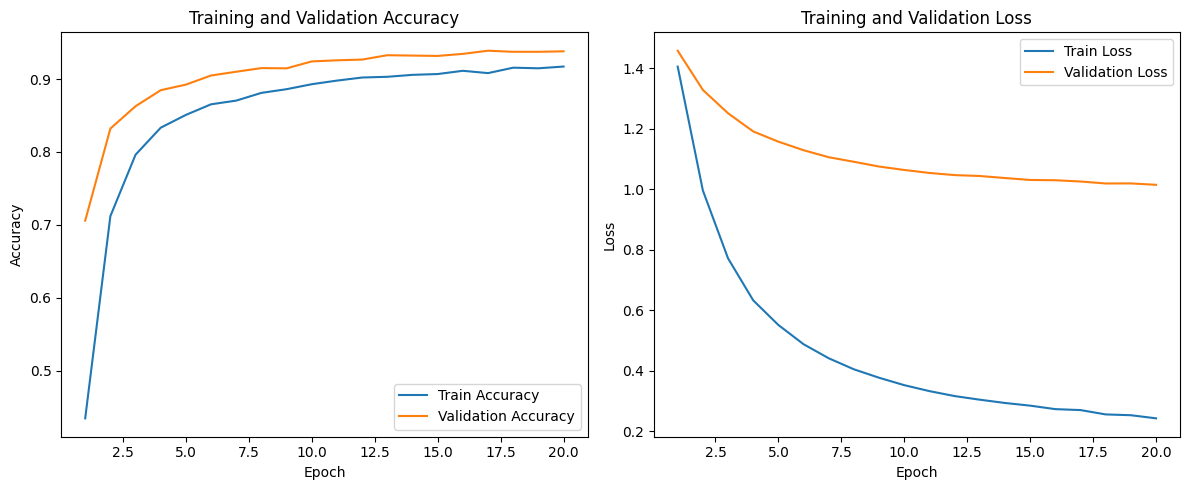

In [75]:
# Training
best_model, history, best_val_accuracy = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
) 


# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

      3dmask       0.97      0.97      0.97      1200
    deepfake       0.79      0.95      0.87      1200
       print       1.00      1.00      1.00      1200
        real       0.92      0.73      0.82      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.93      6000
   macro avg       0.94      0.93      0.93      6000
weighted avg       0.94      0.93      0.93      6000



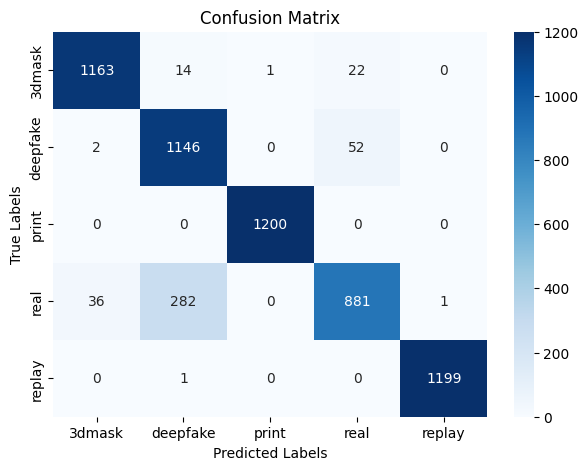

In [76]:
# Model Evaluation
best_model.model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model.model(images)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))


# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [77]:
# Update class metadata before saving
best_model.model.nc = num_classes
best_model.model.names = {i: name for i, name in enumerate(class_names)}  # Dictionary for class name

# Create subfolder with name 'yolo11_{date}_{acc}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"yolo11_{current_date}_{best_val_accuracy:.4f}")
try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model using Ultralytics API
full_model_path = os.path.join(save_dir, 'YOLOv11-full-model.pt')
try:
    best_model.save(full_model_path)  # Save with class metadata
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save checkpoint with history
checkpoint = {
    "model": best_model.model.state_dict(),
    "history": history,
    "best_val_acc": best_val_accuracy,
    "class_names": class_names,
    "nc": num_classes
}
checkpoint_path = os.path.join(save_dir, 'YOLOv11-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Full model saved to /kaggle/working/results/yolo11_10-23-10_0.9388/YOLOv11-full-model.pt
Checkpoint with history saved to /kaggle/working/results/yolo11_10-23-10_0.9388/YOLOv11-with-history.pt
All models successfully saved to /kaggle/working/results/yolo11_10-23-10_0.9388


In [ ]:
# Inference test to make sure custom classes
print("Testing model with custom classes:")
test_model = YOLO(full_model_path)
image_path = "/kaggle/input/dataset-224-splitted-v2/dataset-224-splitted/test/real/real_26_0200.jpg"
results = test_model(image_path, imgsz=224)
probs = results[0].probs
print("Inference output (should use custom names):")
print(results[0])  # Suppose to display custome class
for i, prob in enumerate(probs.data):
    print(f"{test_model.names[i]}: {prob:.4f}")
results[0].show()

## EfficientNetV2

In [5]:
# Check GPU Availability
print(torch.cuda.is_available())

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [6]:
# Hyperparameters

BATCH_SIZE = 32
EPOCHS=20
LR=0.0001
WEIGHT_DECAY=0.05
DROPOUT=0.2

In [7]:
# Create Data Loader 

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [8]:
weights = EfficientNet_V2_S_Weights.DEFAULT
model = efficientnet_v2_s(weights=weights, progress=True)
num_classes = 5
for param in model.features.parameters():
    param.requires_grad = False
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=DROPOUT),
    nn.Linear(in_features, num_classes)
)
model = model.to(device)


In [ ]:
summary(model, input_size=(1, 3, 224, 224))

In [9]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

# Scheduler
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
# scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode='min',    
#     factor=0.5,    
#     patience=2,    
#     min_lr=0.00001,
#     verbose=True   
# )

In [10]:
# Training Function

def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, num_epochs=25):
    """Trains and validates a model, including a learning rate scheduler and logic to save the best model."""
    start_time = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    model.to(device)
    current_lr = LR

    for epoch in range(num_epochs):
        # Get current LR from optimizer
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} => ",
              f"LR: {current_lr:.8f} | ", end='')
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_dataloader
            else:
                model.eval()
                dataloader = val_dataloader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | ', end='')

            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'>>> New best model saved!', end='')
        print()

        # Step the scheduler and print the current learning rate
        # scheduler.step()
        # scheduler.step(history['val_loss'][-1])

    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history, best_val_accuracy

In [11]:
# Training

best_model, history, best_val_acc = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=EPOCHS
)

Epoch 1/20 =>  LR: 0.00010000 | Train Loss: 1.0379 Acc: 0.7293 | Val Loss: 0.5979 Acc: 0.8902 | >>> New best model saved!
Epoch 2/20 =>  LR: 0.00010000 | Train Loss: 0.5911 Acc: 0.8603 | Val Loss: 0.4069 Acc: 0.9010 | >>> New best model saved!
Epoch 3/20 =>  LR: 0.00010000 | Train Loss: 0.4649 Acc: 0.8719 | Val Loss: 0.3216 Acc: 0.9112 | >>> New best model saved!
Epoch 4/20 =>  LR: 0.00010000 | Train Loss: 0.4029 Acc: 0.8806 | Val Loss: 0.2775 Acc: 0.9160 | >>> New best model saved!
Epoch 5/20 =>  LR: 0.00010000 | Train Loss: 0.3679 Acc: 0.8838 | Val Loss: 0.2785 Acc: 0.9135 | 
Epoch 6/20 =>  LR: 0.00010000 | Train Loss: 0.3362 Acc: 0.8918 | Val Loss: 0.2393 Acc: 0.9228 | >>> New best model saved!
Epoch 7/20 =>  LR: 0.00010000 | Train Loss: 0.3150 Acc: 0.8956 | Val Loss: 0.2265 Acc: 0.9253 | >>> New best model saved!
Epoch 8/20 =>  LR: 0.00010000 | Train Loss: 0.3023 Acc: 0.8971 | Val Loss: 0.2091 Acc: 0.9255 | >>> New best model saved!
Epoch 9/20 =>  LR: 0.00010000 | Train Loss: 0.292

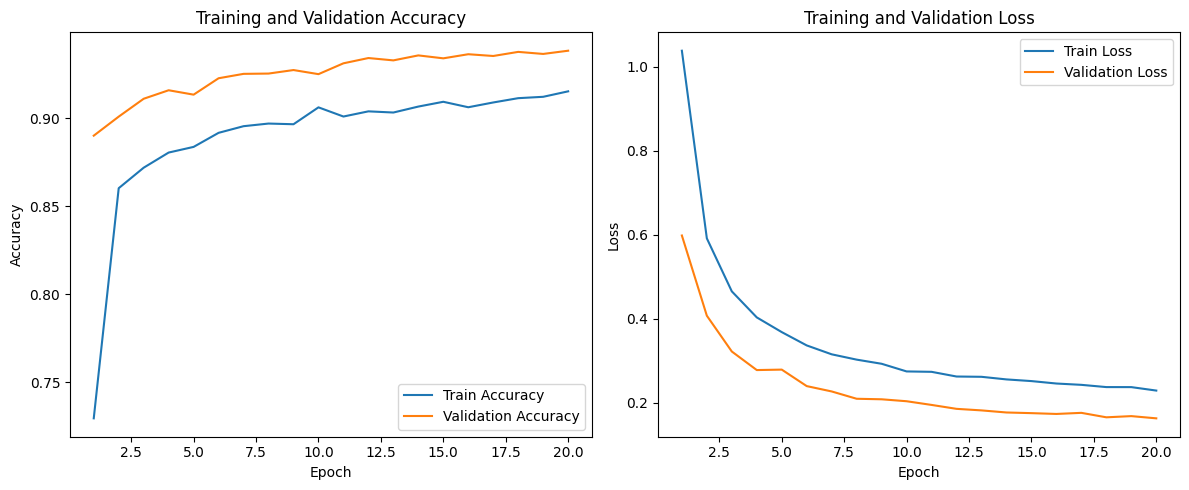

In [12]:
# Plot Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), history["train_acc"], label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), history["train_loss"], label="Train Loss")
plt.plot(range(1, EPOCHS + 1), history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Model Evaluation

best_model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predictions, target_names=test_dataset_ori.classes))

              precision    recall  f1-score   support

      3dmask       0.96      0.99      0.98      1200
    deepfake       0.80      0.96      0.87      1200
       print       1.00      1.00      1.00      1200
        real       0.95      0.73      0.82      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.93      6000
weighted avg       0.94      0.94      0.93      6000



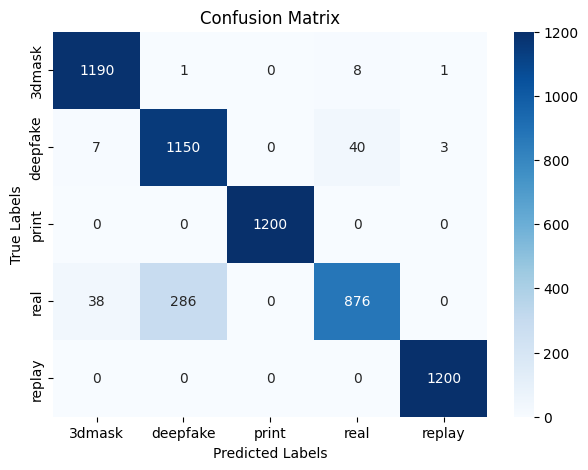

In [14]:
# Confussion Matrix

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset_ori.classes, yticklabels=test_dataset_ori.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [15]:
# Create subfolder with name 'effnet_{date}'
current_date = datetime.now().strftime("%m-%d-%H")
save_dir = os.path.join(folder_save, f"effnet_{current_date}_{best_val_acc:.4f}")

try:
    os.makedirs(save_dir, exist_ok=True)
except OSError as e:
    print(f"Error creating directory {save_dir}: {e}")
    raise

# Save model weights only
weights_path = os.path.join(save_dir, 'EfficientNetV2-weights-only-dict.pt')
try:
    torch.save(best_model.state_dict(), weights_path)
    print(f"Weights saved to {weights_path}")
except Exception as e:
    print(f"Error saving weights to {weights_path}: {e}")
    raise

# Save full model
full_model_path = os.path.join(save_dir, 'EfficientNetV2-full-model.pt')
try:
    torch.save(best_model, full_model_path)
    print(f"Full model saved to {full_model_path}")
except Exception as e:
    print(f"Error saving full model to {full_model_path}: {e}")
    raise

# Save model with history
checkpoint = {
    "model": best_model.state_dict(),
    "history": history,
    "best_val_acc": best_val_acc
}
checkpoint_path = os.path.join(save_dir, 'EfficientNetV2-with-history.pt')
try:
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint with history saved to {checkpoint_path}")
except Exception as e:
    print(f"Error saving checkpoint to {checkpoint_path}: {e}")
    raise

print(f"All models successfully saved to {save_dir}")

Weights saved to /kaggle/working/results/effnet_10-22-07_0.9385/EfficientNetV2-weights-only-dict.pt
Full model saved to /kaggle/working/results/effnet_10-22-07_0.9385/EfficientNetV2-full-model.pt
Checkpoint with history saved to /kaggle/working/results/effnet_10-22-07_0.9385/EfficientNetV2-with-history.pt
All models successfully saved to /kaggle/working/results/effnet_10-22-07_0.9385


# Ensemble Weighted Average

In [6]:
import os, random, numpy as np, torch

os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True, warn_only=True)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(42)

In [8]:
import logging
logging.getLogger("ultralytics").setLevel(logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)

In [11]:
# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
# RANDOM_STATE = 42
NUM_CLASSES = 5  # 5 classes: 3dmask, deepfake, print, real, replay
BATCH_SIZE = 32
N_SPLITS = 5
random.seed(42)
np.random.seed(42)

# Paths
data_dir = "/kaggle/working/dataset-s1-v2-602020"
folder_save = "/kaggle/working/results"

In [12]:
# Class names
class_names = train_dataset.datasets[0].classes
print("Classes:", class_names)

# Create DataLoader
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, worker_init_fn=seed_worker, generator=g)
# val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, worker_init_fn=seed_worker, generator=g)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, worker_init_fn=seed_worker, generator=g)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Model paths (assuming saved as per your code)
yolo_model_path = os.path.join('/kaggle/working/results/yolo11_10-21-17_0.9682/YOLOv11-full-model.pt')  # Example accuracy
effnet_model_path = os.path.join('/kaggle/working/results/effnet_10-22-07_0.9385/EfficientNetV2-weights-only-dict.pt')  # Example accuracy
single_image_path = os.path.join('/kaggle/input/dataset-s1/real/real_05_0001.jpg')  # Example test image

Classes: ['3dmask', 'deepfake', 'print', 'real', 'replay']


In [13]:
# Transform
transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [22]:
# Liveness Ensemble Pipeline (Grid Search Accuracy-ACER-based)
class LivenessEnsemblePipeline:
    def __init__(self, yolo_model, effnet_path, device, val_loader, step=0.001, manual_weights=None):
        # self.device = device
        # self.classes = ['3dmask', 'deepfake', 'print', 'real', 'replay']

        # # Load YOLOv11-cls (as YOLO object, already initialized outside)
        # print("--- Loading model: Yolo11-cls ---")
        # self.yolo_model = YOLO(yolo_model_path)
        # self.yolo_model_core = self.yolo_model.model
        # self.yolo_model_core.to(device).eval()
        # self.yolo_model_names = self.yolo_model.names
        # print(f"Model successfully loaded")

        # # Load EfficientNetV2
        # print("\n--- Loading model type: EfficientNetV2 ---")
        # self.effnet_model = models.efficientnet_v2_s(weights=None)
        # num_ftrs = self.effnet_model.classifier[1].in_features
        # self.effnet_model.classifier[1] = nn.Linear(num_ftrs, len(self.classes))
        # state_dict = torch.load(effnet_path, map_location=device)
        # self.effnet_model.load_state_dict(state_dict)
        # self.effnet_model.to(device).eval()
        # print(f"Model successfully loaded from: {effnet_path}")

        # # Grid search for single weights (overall ACER)
        # self.weights = self._grid_search_weights(val_loader, step)
        # print(f"Optimal weights (Yolo11-cls, EfficientNetV2): {self.weights}")

        self.device = device
        self.classes = ['3dmask', 'deepfake', 'print', 'real', 'replay']

        # Load YOLOv11
        print("--- Loading model: YOLOv11-cls ---")
        self.yolo_model = YOLO(yolo_model_path)
        self.yolo_model_core = self.yolo_model.model
        self.yolo_model_core.to(device).eval()
        print("YOLOv11 loaded successfully")

        # Load EfficientNetV2
        print("\n--- Loading model: EfficientNetV2 ---")
        self.effnet_model = models.efficientnet_v2_s(weights=None)
        num_ftrs = self.effnet_model.classifier[1].in_features
        self.effnet_model.classifier[1] = nn.Linear(num_ftrs, len(self.classes))
        state_dict = torch.load(effnet_path, map_location=device)
        self.effnet_model.load_state_dict(state_dict)
        self.effnet_model.to(device).eval()
        print("EfficientNetV2 loaded successfully")

        if manual_weights is not None:
            if len(manual_weights) != 2:
                raise ValueError("manual_weights must be [w_yolo, w_effnet]")
            w_y, w_e = manual_weights
            if abs(w_y + w_e - 1.0) > 1e-6:
                print(f"[WARNING] Weights not 100%: {w_y + w_e:.4f} → will be normalized")
                total = w_y + w_e
                w_y, w_e = w_y / total, w_e / total
            self.weights = [float(w_y), float(w_e)]
            print(f"YOLOv11: {self.weights[0]:.4f}, EfficientNetV2: {self.weights[1]:.4f}")
        else:
            if val_loader is None:
                raise ValueError("val_loader should be added")
            print("Run grid search...")
            self.weights = self._grid_search_weights(val_loader, step)
        
        print(f"Final weights (YOLOv11, EfficientNetV2): {self.weights}")

    # Metric calculation
    def _calculate_metrics(self, all_labels, all_preds):
        real_idx = self.classes.index('real')
        attack_indices = [i for i in range(len(self.classes)) if i != real_idx]
    
        # BPCER
        total_real = np.sum(np.array(all_labels) == real_idx)
        fn_real = np.sum((np.array(all_preds)[np.array(all_labels) == real_idx] != real_idx))
        bpcer = fn_real / total_real if total_real > 0 else 0.0
    
        # APCER per attack class
        apcer_dict = {}
        for atk_idx in attack_indices:
            atk_mask = np.array(all_labels) == atk_idx
            total_atk = np.sum(atk_mask)
            fp_atk = np.sum(np.array(all_preds)[atk_mask] == real_idx)
            apcer_dict[self.classes[atk_idx]] = fp_atk / total_atk if total_atk > 0 else 0.0
    
        # APCER overall
        total_attack = np.sum(np.isin(all_labels, attack_indices))
        fp_real = np.sum((np.array(all_preds)[np.isin(all_labels, attack_indices)] == real_idx))
        apcer_overall = fp_real / total_attack if total_attack > 0 else 0.0
    
        acer = (bpcer + apcer_overall) / 2
        return bpcer, apcer_dict, apcer_overall, acer

    # Weighted ensemble ACER
    def _ensemble_acer(self, weights, probs_list, labels):
        ensemble_probs = weights[0] * probs_list[0] + weights[1] * probs_list[1]
        preds = np.argmax(ensemble_probs, axis=1)
        _, _, acer = self._calculate_metrics(labels, preds)
        return acer

    # Grid search for one weight per model
    def _grid_search_weights(self, val_loader, step=0.001):
        print("\n--- Performing Grid Search for Overall Weights ---")
        best_acer = float('inf')
        best_weight = None

        yolo_probs, effnet_probs, all_labels = [], [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(self.device)

                # YOLO predictions
                yolo_out = self.yolo_model_core(images)
                if isinstance(yolo_out, tuple):
                    yolo_out = yolo_out[0]
                yolo_probs.extend(torch.softmax(yolo_out, dim=1).cpu().numpy())

                # EffNet predictions
                effnet_out = self.effnet_model(images)
                effnet_probs.extend(torch.softmax(effnet_out, dim=1).cpu().numpy())

                all_labels.extend(labels.numpy())

        yolo_probs = np.array(yolo_probs)
        effnet_probs = np.array(effnet_probs)
        all_labels = np.array(all_labels)
        probs_list = [yolo_probs, effnet_probs]

        for w_yolo in np.arange(0, 1 + step, step):
            w_effnet = 1.0 - w_yolo
            acer = self._ensemble_acer([w_yolo, w_effnet], probs_list, all_labels)
            print(f"Weights [Yolo: {w_yolo:.2f}, EffNet: {w_effnet:.2f}] -> ACER: {acer:.4f}")
            if acer < best_acer:
                best_acer = acer
                best_weight = [w_yolo, w_effnet]

        print(f"Best ACER on val set: {best_acer:.4f}")
        return best_weight

    # Prediction single image
    def predict_single(self, image_path):
        # YOLO Prediction
        yolo_class, yolo_conf, yolo_probs, yolo_time = self._predict_yolo(image_path)
        self._print_single_results("Yolo11-cls", yolo_class, yolo_conf, yolo_probs, yolo_time)
        
        # EfficientNet Prediction
        effnet_class, effnet_conf, effnet_probs, effnet_time = self._predict_effnet(image_path)
        self._print_single_results("EfficientNetV2", effnet_class, effnet_conf, effnet_probs, effnet_time)
        
        # Ensemble Prediction
        ensemble_class, ensemble_conf, ensemble_probs, ensemble_time = self._predict_ensemble(yolo_probs, effnet_probs)
        # Gunakan format sama dengan _print_single_results
        self._print_single_results("Ensemble", ensemble_class, ensemble_conf, ensemble_probs, ensemble_time)

    # Model-specific prediction
    def _predict_yolo(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(self.device)
        
        start_time = time.time()
        with torch.no_grad():
            outputs = self.yolo_model_core(image_tensor)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()
        end_time = time.time()
        
        pred_idx = np.argmax(probs)
        inference_time = end_time - start_time
        
        return self.classes[pred_idx], probs[pred_idx], probs, inference_time

    def _predict_effnet(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(self.device)
        
        start_time = time.time()
        with torch.no_grad():
            outputs = self.effnet_model(image_tensor)
            probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()
        end_time = time.time()
        
        pred_idx = np.argmax(probs)
        inference_time = end_time - start_time
        
        return self.classes[pred_idx], probs[pred_idx], probs, inference_time

    def _predict_ensemble(self, yolo_probs, effnet_probs):
        start_time = time.time()
        w_yolo, w_effnet = self.weights
        ensemble_probs = w_yolo * yolo_probs + w_effnet * effnet_probs
        pred_idx = np.argmax(ensemble_probs)
        end_time = time.time()
        
        inference_time = end_time - start_time
        
        return self.classes[pred_idx], ensemble_probs[pred_idx], ensemble_probs, inference_time

    def _print_single_results(self, model_name, pred_class, conf, probs, time_taken):
        print(f"\n--- Prediction Results ---")
        print(f"Model: {model_name}")
        print(f"Predicted Class: {pred_class}")
        print(f"Confidence Level: {conf:.4f}")
        print("Probabilities for all classes:")
        for i, cls in enumerate(self.classes):
            print(f"* {cls.capitalize()}: {probs[i]:.4f}")
        print(f"Prediction completed in {time_taken:.4f} seconds.")
    
    # Full evaluation method
    def evaluate(self, test_loader):
        print("\n--- Evaluating Models ---")
        self._evaluate_model(test_loader, self.yolo_model_core, "Yolo11-cls")
        self._evaluate_model(test_loader, self.effnet_model, "EfficientNetV2")
        self._evaluate_ensemble(test_loader)

    def _evaluate_model(self, loader, model, name):
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in loader:
                images = images.to(self.device)
                outputs = model(images)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.numpy())

        report = classification_report(all_labels, all_preds, target_names=self.classes, zero_division=0)
        acc = accuracy_score(all_labels, all_preds)
        bpcer, apcer_dict, apcer_overall, acer = self._calculate_metrics(all_labels, all_preds)

        # APCER Overall
        real_idx = self.classes.index('real')
        attack_indices = [i for i in range(len(self.classes)) if i != real_idx]
        total_attack = np.sum(np.isin(all_labels, attack_indices))
        fp_real = np.sum((np.array(all_preds)[np.isin(all_labels, attack_indices)] == real_idx))
        apcer_overall = fp_real / total_attack if total_attack > 0 else 0.0

        print(f"\n--- Evaluation of Model: {name} ---")
        print(report)
        print(f"Accuracy: {acc:.4f}, BPCER: {bpcer:.4f}, APCER Overall: {apcer_overall:.4f}, ACER: {acer:.4f}")
        print("APCER per attack class:")
        for cls, val in apcer_dict.items():
            print(f"* {cls}: {val:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(7, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=self.classes, yticklabels=self.classes)
        plt.title(f"Confusion Matrix for {name}")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

    def _evaluate_ensemble(self, loader):
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in loader:
                images = images.to(self.device)

                # YOLO probs
                yolo_out = self.yolo_model_core(images)
                if isinstance(yolo_out, tuple):
                    yolo_out = yolo_out[0]
                yolo_probs = torch.softmax(yolo_out, dim=1).cpu().numpy()

                # EffNet probs
                eff_out = self.effnet_model(images)
                eff_probs = torch.softmax(eff_out, dim=1).cpu().numpy()

                # Ensemble predictions
                batch_preds = []
                for y_probs, e_probs in zip(yolo_probs, eff_probs):
                    _, _, ens_probs, _ = self._predict_ensemble(y_probs, e_probs)
                    batch_preds.append(np.argmax(ens_probs))
                all_preds.extend(batch_preds)
                all_labels.extend(labels.numpy())

        report = classification_report(all_labels, all_preds, target_names=self.classes, zero_division=0)
        acc = accuracy_score(all_labels, all_preds)
        bpcer, apcer_dict, apcer_overall, acer = self._calculate_metrics(all_labels, all_preds)

        # APCER Overall
        real_idx = self.classes.index('real')
        attack_indices = [i for i in range(len(self.classes)) if i != real_idx]
        total_attack = np.sum(np.isin(all_labels, attack_indices))
        fp_real = np.sum((np.array(all_preds)[np.isin(all_labels, attack_indices)] == real_idx))
        apcer_overall = fp_real / total_attack if total_attack > 0 else 0.0

        print(f"\n--- Evaluation of Model: Ensemble ---")
        print(report)
        print(f"Accuracy: {acc:.4f}, BPCER: {bpcer:.4f}, APCER Overall: {apcer_overall:.4f}, ACER: {acer:.4f}")
        print("APCER per attack class:")
        for cls, val in apcer_dict.items():
            print(f"* {cls}: {val:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(7, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=self.classes, yticklabels=self.classes)
        plt.title("Confusion Matrix for Ensemble Model")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

    
    # AUC and ROI
    def evaluate_with_roc(self, test_loader):
        """
        ROC Curve + AUC (One-vs-Rest) for 3 models:
        - YOLOv11
        - EfficientNetV2  
        - Ensemble (weighted)
        Output: 1 plot + tabel AUC per class + macro-average AUC
        """
        print("\n" + "="*70)
        print(" ROC CURVE & AUC EVALUATION (5 CLASS: 3dmask, deepfake, print, real, replay)")
        print("="*70)

        # Koleksi probabilitas
        y_true = []
        yolo_probs_all   = []
        effnet_probs_all = []
        ensemble_probs_all = []

        self.yolo_model_core.eval()
        self.effnet_model.eval()

        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(self.device)
                labels_np = labels.cpu().numpy()
                y_true.extend(labels_np)

                # YOLOv11
                yolo_out = self.yolo_model_core(images)
                if isinstance(yolo_out, tuple):
                    yolo_out = yolo_out[0]
                yolo_prob = torch.softmax(yolo_out, dim=1).cpu().numpy()
                yolo_probs_all.extend(yolo_prob)

                # EfficientNetV2
                eff_out = self.effnet_model(images)
                eff_prob = torch.softmax(eff_out, dim=1).cpu().numpy()
                effnet_probs_all.extend(eff_prob)

                # Ensemble
                w_y, w_e = self.weights
                ens_prob = w_y * yolo_prob + w_e * eff_prob
                ensemble_probs_all.extend(ens_prob)

        # Convert to array
        y_true = np.array(y_true)
        yolo_probs_all   = np.array(yolo_probs_all)
        effnet_probs_all = np.array(effnet_probs_all)
        ensemble_probs_all = np.array(ensemble_probs_all)

        # Binarize labels (One-vs-Rest)
        n_classes = len(self.classes)
        y_true_bin = label_binarize(y_true, classes=range(n_classes))

        # Model dictionary
        models = {
            'YOLOv11': yolo_probs_all,
            'EfficientNetV2': effnet_probs_all,
            'Ensemble': ensemble_probs_all
        }

        # Setup plot
        plt.figure(figsize=(7, 5))
        colors = cycle(['blue', 'orange', 'red'])  # biru, oranye, hijau

        # AUC Table
        print("\nAUC PER CLASS (One-vs-Rest)\n")
        print(f"{'Class':<12} {'YOLOv11':<10} {'EffNetV2':<12} {'Ensemble':<10}")
        print("-" * 55)

        # Calculate AUC per class + plot per-class
        fpr_dict = {}
        tpr_dict = {}
        auc_dict = {}

        for i, cls in enumerate(self.classes):
            auc_scores = []
            for name, probs in models.items():
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
                roc_auc = auc(fpr, tpr)
                auc_scores.append(roc_auc)

                if name not in fpr_dict:
                    fpr_dict[name] = []
                    tpr_dict[name] = []
                    auc_dict[name] = []
                fpr_dict[name].append(fpr)
                tpr_dict[name].append(tpr)
                auc_dict[name].append(roc_auc)

            print(f"{cls.capitalize():<12} {auc_scores[0]:.4f}     {auc_scores[1]:.4f}       {auc_scores[2]:.4f}")

        # Macro-average ROC
        all_fpr = np.unique(np.concatenate([fpr_dict['YOLOv11'][i] for i in range(n_classes)]))
        macro_aucs = {}

        for name in models.keys():
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(n_classes):
                mean_tpr += np.interp(all_fpr, fpr_dict[name][i], tpr_dict[name][i])
            mean_tpr /= n_classes
            mean_tpr[0] = 0.0
            mean_tpr[-1] = 1.0
            macro_auc = auc(all_fpr, mean_tpr)
            macro_aucs[name] = macro_auc

            color = next(colors)
            plt.plot(all_fpr, mean_tpr, 
                     color=color, lw=1.2, linestyle='-',
                     label=f'{name} macro-avg (AUC = {macro_auc:.4f})')

        # Diagonal Line
        plt.plot([0, 1], [0, 1], 'k--', lw=1.2, label='Random (AUC = 0.50)')

        # Plot Finalization
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('Multi-class ROC Curve (One-vs-Rest)', fontsize=14)
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Print final macro AUC
        print(f"\n{'='*60}")
        print("FINAL MACRO-AVERAGE AUC")
        print(f"{'='*60}")
        for name, mauc in macro_aucs.items():
            print(f"{name:15}: {mauc:.4f}")
        print(f"{'='*60}")


    # Time Evaluation
    def benchmark_inference_time(self, test_loader):
        """
        Measure inference time on THE ENTIRE test set
        Output: Clean table + FPS
        """
        print("\n" + "="*70)
        print(" INFERENCE TIME BENCHMARK (ON FULL TEST SET)")
        print("="*70)

        # Calculate test set data
        total_images = len(test_loader.dataset)
        print(f"Test set size: {total_images:,} images")

        # Timer lists
        yolo_times = []
        effnet_times = []
        ensemble_times = []

        self.yolo_model_core.eval()
        self.effnet_model.eval()

        with torch.no_grad():
            for images, _ in test_loader:
                images = images.to(self.device)
                batch_size = images.size(0)

                # === YOLOv11 ===
                torch.cuda.synchronize() if self.device.type == 'cuda' else None
                start = time.time()
                _ = self.yolo_model_core(images)
                torch.cuda.synchronize() if self.device.type == 'cuda' else None
                yolo_times.append(time.time() - start)

                # === EfficientNetV2 ===
                torch.cuda.synchronize() if self.device.type == 'cuda' else None
                start = time.time()
                _ = self.effnet_model(images)
                torch.cuda.synchronize() if self.device.type == 'cuda' else None
                effnet_times.append(time.time() - start)

                # === Ensemble (full pipeline) ===
                torch.cuda.synchronize() if self.device.type == 'cuda' else None
                start = time.time()
                y_out = self.yolo_model_core(images)
                e_out = self.effnet_model(images)
                w_y, w_e = self.weights
                ens_out = w_y * torch.softmax(y_out[0] if isinstance(y_out, tuple) else y_out, dim=1) + \
                          w_e * torch.softmax(e_out, dim=1)
                _ = torch.argmax(ens_out, dim=1)
                torch.cuda.synchronize() if self.device.type == 'cuda' else None
                ensemble_times.append(time.time() - start)

        # Calculate time average
        avg_yolo = (sum(yolo_times) / total_images) * 1000
        avg_eff  = (sum(effnet_times) / total_images) * 1000
        avg_ens  = (sum(ensemble_times) / total_images) * 1000

        std_yolo = (np.std(yolo_times) / np.sqrt(len(yolo_times))) * 1000 / (total_images / len(yolo_times))
        std_eff  = (np.std(effnet_times) / np.sqrt(len(effnet_times))) * 1000 / (total_images / len(effnet_times))
        std_ens  = (np.std(ensemble_times) / np.sqrt(len(ensemble_times))) * 1000 / (total_images / len(ensemble_times))

        # Print table
        print(f"\n{'Model':<20} {'Time (ms)':<15} {'FPS':<8} {'± std'}")
        print("-" * 65)
        print(f"{'YOLOv11-cls':<20} {avg_yolo:6.4f}       {1000/avg_yolo:6.4f}    ± {std_yolo:.4f}")
        print(f"{'EfficientNetV2':<20} {avg_eff:6.4f}       {1000/avg_eff:6.4f}    ± {std_eff:.4f}")
        print(f"{'Ensemble':<20} {avg_ens:6.4f}       {1000/avg_ens:6.4f}    ± {std_ens:.4f}")
        print("-" * 65)
        print(f"Real-time threshold: >30 FPS → Ensemble: {1000/avg_ens:.4f} FPS")

        return {
            'total_images': total_images,
            'yolo_ms': avg_yolo, 'effnet_ms': avg_eff, 'ensemble_ms': avg_ens,
            'yolo_fps': 1000/avg_yolo, 'effnet_fps': 1000/avg_eff, 'ensemble_fps': 1000/avg_ens
        }

In [ ]:
# Execute pipeline
if __name__ == "__main__":
    pipeline = LivenessEnsemblePipeline(
        yolo_model_path,
        effnet_model_path,
        DEVICE,
        val_dataloader        
    )

--- Loading model: YOLOv11-cls ---
YOLOv11 loaded successfully

--- Loading model: EfficientNetV2 ---
EfficientNetV2 loaded successfully
YOLOv11: 0.8920, EfficientNetV2: 0.1080
Final weights (YOLOv11, EfficientNetV2): [0.892, 0.108]



=== Evaluation ===

--- Evaluating Models ---

--- Evaluation of Model: Yolo11-cls ---
              precision    recall  f1-score   support

      3dmask       0.99      1.00      0.99      1200
    deepfake       0.90      0.93      0.92      1200
       print       1.00      1.00      1.00      1200
        real       0.93      0.89      0.91      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000

Accuracy: 0.9642, BPCER: 0.1067, APCER Overall: 0.0177, ACER: 0.0622
APCER per attack class:
* 3dmask: 0.0008
* deepfake: 0.0700
* print: 0.0000
* replay: 0.0000


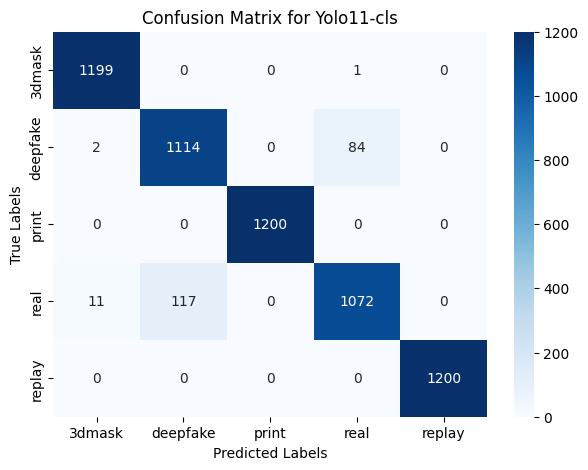


--- Evaluation of Model: EfficientNetV2 ---
              precision    recall  f1-score   support

      3dmask       0.95      0.99      0.97      1200
    deepfake       0.80      0.96      0.87      1200
       print       1.00      1.00      1.00      1200
        real       0.95      0.71      0.81      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.93      6000
   macro avg       0.94      0.93      0.93      6000
weighted avg       0.94      0.93      0.93      6000

Accuracy: 0.9332, BPCER: 0.2850, APCER Overall: 0.0102, ACER: 0.1476
APCER per attack class:
* 3dmask: 0.0100
* deepfake: 0.0308
* print: 0.0000
* replay: 0.0000


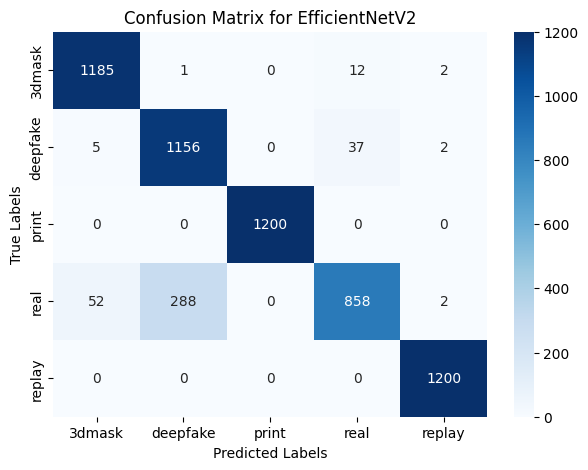


--- Evaluation of Model: Ensemble ---
              precision    recall  f1-score   support

      3dmask       0.99      1.00      1.00      1200
    deepfake       0.91      0.96      0.93      1200
       print       1.00      1.00      1.00      1200
        real       0.96      0.90      0.93      1200
      replay       1.00      1.00      1.00      1200

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000

Accuracy: 0.9715, BPCER: 0.1025, APCER Overall: 0.0094, ACER: 0.0559
APCER per attack class:
* 3dmask: 0.0000
* deepfake: 0.0375
* print: 0.0000
* replay: 0.0000


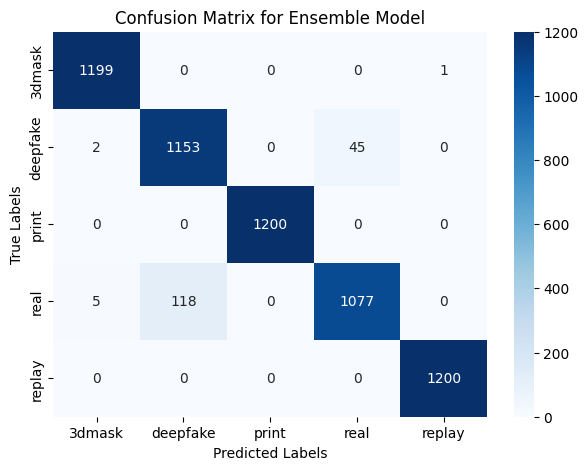

In [26]:
# Execution for Evaluation
if __name__ == "__main__":
    print("\n=== Evaluation ===")
    pipeline.evaluate(test_dataloader)

In [17]:
# Execution for Time Evaluation
if __name__ == "__main__":
    print("\n=== Time Evaluation ===")
    results = pipeline.benchmark_inference_time(test_dataloader)


=== Time Evaluation ===

 INFERENCE TIME BENCHMARK (ON FULL TEST SET)
Test set size: 6,000 images

Model                Time (ms)       FPS      ± std
-----------------------------------------------------------------
YOLOv11-cls          0.4426       2259.2893    ± 0.0696
EfficientNetV2       1.7175       582.2497    ± 0.0073
Ensemble             2.0729       482.4271    ± 0.0053
-----------------------------------------------------------------
Real-time threshold: >30 FPS → Ensemble: 482.4271 FPS



=== ROC CURVE + AUC (5-class One-vs-Rest) ===

 ROC CURVE & AUC EVALUATION (5 CLASS: 3dmask, deepfake, print, real, replay)

AUC PER CLASS (One-vs-Rest)

Class        YOLOv11    EffNetV2     Ensemble  
-------------------------------------------------------
3dmask       1.0000     0.9994       1.0000
Deepfake     0.9939     0.9825       0.9949
Print        1.0000     1.0000       1.0000
Real         0.9930     0.9768       0.9944
Replay       1.0000     1.0000       1.0000


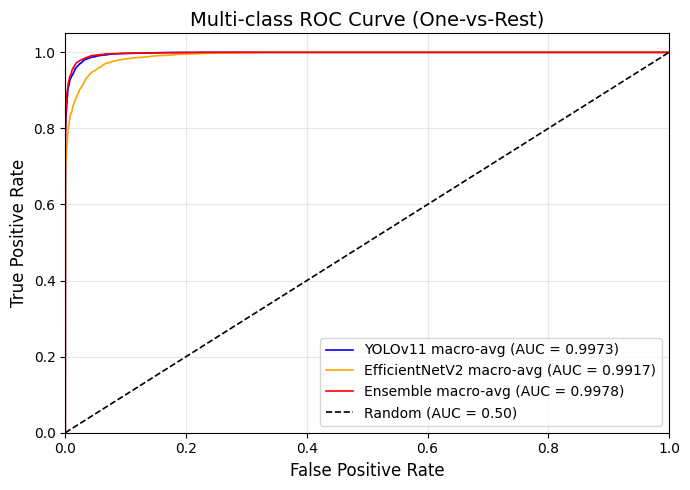


FINAL MACRO-AVERAGE AUC
YOLOv11        : 0.9973
EfficientNetV2 : 0.9917
Ensemble       : 0.9978


In [25]:
# Execution for ROI
if __name__ == "__main__":
    print("\n=== ROC CURVE + AUC (5-class One-vs-Rest) ===")
    pipeline.evaluate_with_roc(test_dataloader)